# SVM Classification - Fake vs Real Restaurant Reviews

This notebook trains an SVM classifier to distinguish between fake and real restaurant reviews using 10 extracted NLP features.

**Features:** AWL, ASL, NOW, NVB, NAJ, NPV, NST, CDV, NTP, TPR

**Pipeline:**
1. Data split (60/20/20) with stratification for equal class distribution and shuffling
2. StandardScaler normalization (SVM is distance-based, so feature scales matter)
3. Feature Selection using SelectKBest (ANOVA F-test) applied before tuning
4. 5-fold Cross Validation with Hyperparameter Tuning (GridSearchCV) on train+val set
5. Multiple kernels tested: Linear, Polynomial, and RBF
6. Retrain best model on full train+val set, evaluate on held-out test set
7. Report Accuracy, F1-score, number of selected features, and feature ranking

**Benchmark:** Accuracy 79.09, F1 76.99

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler

## Step 1 - Load Data and Split (60/20/20)

In [2]:
df = pd.read_csv("../../data/preprocessed/reviewFeatures.csv")
print(f"Dataset shape: {df.shape}")
print(f"\nClass distribution:")
print(df["Real=1/Fake=0"].value_counts())
df.head()

Dataset shape: (260, 11)

Class distribution:
Real=1/Fake=0
0    130
1    130
Name: count, dtype: int64


,Real=1/Fake=0,AWL,ASL,NOW,NVB,NAJ,NPV,NST,CDV,NTP,TPR
0,0,4.67,16.60,83,12,6,0,5,0.89,5,0.06
1,0,4.07,18.17,109,15,8,2,6,0.95,4,0.04
2,0,3.61,16.00,112,15,4,4,7,0.86,1,0.01
3,0,4.39,15.25,61,9,7,0,4,0.92,1,0.02
4,0,4.50,14.80,74,10,9,0,5,0.90,0,0.00


In [3]:
"""
  Split data into train/val/test (60/20/20).
  Uses stratify to ensure equal class distribution in each subset.
  StandardScaler fitted on training data only to prevent data leakage.
"""
def train_test_valid_split(df, target):
    y = df[target].values
    X = df.drop(target, axis=1)
    feature_names = X.columns.tolist()

    # First split: 80% train+val, 20% test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=101, shuffle=True, stratify=y
    )
    # Second split: 75% train, 25% val (of the 80%) = 60/20 overall
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.25, random_state=101, stratify=y_train
    )

    # Scale features - fit on training data only
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_names, index=X_train.index)
    X_val = pd.DataFrame(scaler.transform(X_val), columns=feature_names, index=X_val.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=feature_names, index=X_test.index)

    return X_train, X_test, X_val, y_train, y_test, y_val, scaler, feature_names

In [4]:
target = "Real=1/Fake=0"
X_train, X_test, X_val, y_train, y_test, y_val, scaler, feature_names = train_test_valid_split(df, target)

print(f"Train: {X_train.shape[0]} samples | Real: {sum(y_train==1)}, Fake: {sum(y_train==0)}")
print(f"Val:   {X_val.shape[0]} samples | Real: {sum(y_val==1)}, Fake: {sum(y_val==0)}")
print(f"Test:  {X_test.shape[0]} samples | Real: {sum(y_test==1)}, Fake: {sum(y_test==0)}")

Train: 156 samples | Real: 78, Fake: 78
Val:   52 samples | Real: 26, Fake: 26
Test:  52 samples | Real: 26, Fake: 26


## Step 2 - Helper Functions

In [5]:
"""
  Merges training and validation data for K-Fold CV.
"""
def concat_train_valid(X_train, y_train, X_val, y_val):
    X = pd.concat([X_train, X_val])
    y = np.concatenate([y_train, y_val])
    return X, y

"""
  Evaluates the SVM model on a given set.
  Returns accuracy and F1 score.
"""
def evaluate(model, X, y, ds_type, selector=None):
    if selector is not None:
        X = selector.transform(X)

    predictions = model.predict(X)
    acc = accuracy_score(y, predictions)
    f1 = f1_score(y, predictions)

    print(f"{ds_type} - Accuracy: {acc*100:.2f}% | F1: {f1*100:.2f}%")
    return acc, f1

## Step 3 - Merge Train+Val for Cross-Validation

Combine training and validation sets for 5-fold CV. The held-out test set remains untouched until final evaluation.

In [6]:
X_train_val, y_train_val = concat_train_valid(X_train, y_train, X_val, y_val)
print(f"Train+Val: {X_train_val.shape[0]} samples | Real: {sum(y_train_val==1)}, Fake: {sum(y_train_val==0)}")

Train+Val: 208 samples | Real: 104, Fake: 104


## Step 4 - Multi-Kernel Hyperparameter Search (5-Fold CV)

We test three SVM kernels with tailored hyperparameter grids:
- **Linear**: Only C matters. Good for small datasets with few features.
- **Polynomial**: C + degree + coef0. Can capture feature interactions.
- **RBF**: C + gamma. Powerful but prone to overfitting on small data.

GridSearchCV with 5-fold CV and F1 scoring finds the best combination.

In [7]:
# Define separate param grids for each kernel
param_grids = [
    {
        'kernel': ['linear'],
        'C': [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
    },
    {
        'kernel': ['poly'],
        'C': [0.01, 0.1, 1, 10, 100],
        'degree': [2, 3],
        'gamma': ['scale', 'auto', 0.01, 0.1],
        'coef0': [0, 1]
    },
    {
        'kernel': ['rbf'],
        'C': [0.01, 0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
    }
]

grid_search = GridSearchCV(
    SVC(random_state=101),
    param_grids,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    refit=True,
    return_train_score=True
)

grid_search.fit(X_train_val, y_train_val)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV F1: {grid_search.best_score_:.4f}")

Best Parameters: {'C': 100, 'coef0': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Best CV F1: 0.6011


In [8]:
# Show best result per kernel to justify kernel choice
results_df = pd.DataFrame(grid_search.cv_results_)

for kernel in ['linear', 'poly', 'rbf']:
    mask = results_df['param_kernel'] == kernel
    if mask.any():
        best_idx = results_df.loc[mask, 'mean_test_score'].idxmax()
        row = results_df.loc[best_idx]
        print(f"{kernel.upper():6s} | Best CV F1: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f}) | Params: {row['params']}")

LINEAR | Best CV F1: 0.5797 (+/- 0.0522) | Params: {'C': 0.5, 'kernel': 'linear'}
POLY   | Best CV F1: 0.6011 (+/- 0.0614) | Params: {'C': 100, 'coef0': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
RBF    | Best CV F1: 0.6004 (+/- 0.0361) | Params: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [9]:
svm_all = grid_search.best_estimator_

print(f"=== Best SVM - All 10 Features ({svm_all.kernel} kernel) ===")
acc_train_all, f1_train_all = evaluate(svm_all, X_train_val, y_train_val, "Train+Val")
acc_test_all, f1_test_all = evaluate(svm_all, X_test, y_test, "Test")

print(f"\nClassification Report (Test):")
print(classification_report(y_test, svm_all.predict(X_test), target_names=["Fake", "Real"]))

=== Best SVM - All 10 Features (poly kernel) ===
Train+Val - Accuracy: 78.37% | F1: 77.83%
Test - Accuracy: 57.69% | F1: 54.17%

Classification Report (Test):
              precision    recall  f1-score   support

        Fake       0.57      0.65      0.61        26
        Real       0.59      0.50      0.54        26

    accuracy                           0.58        52
   macro avg       0.58      0.58      0.57        52
weighted avg       0.58      0.58      0.57        52



## Step 5 - Feature Selection (SelectKBest)

Use SelectKBest with ANOVA F-test to rank features by discriminative power. We search over k=3..10 combined with the multi-kernel grid to find the optimal (features, kernel, hyperparameters) combination.

**Justification for ANOVA F-test:** It measures how well each individual feature separates the two classes (Fake vs Real). Features with high F-scores have significantly different means across classes, making them more useful for classification.

In [10]:
# Rank all features by ANOVA F-score
selector_all = SelectKBest(score_func=f_classif, k='all')
selector_all.fit(X_train_val, y_train_val)

feature_scores = pd.DataFrame({
    'Feature': feature_names,
    'F-Score': selector_all.scores_,
    'p-value': selector_all.pvalues_
}).sort_values('F-Score', ascending=False)

print("Feature Ranking (ANOVA F-test):")
print(feature_scores.to_string(index=False))
print(f"\nStatistically significant features (p < 0.05): {feature_scores[feature_scores['p-value'] < 0.05]['Feature'].tolist()}")

Feature Ranking (ANOVA F-test):
Feature   F-Score      p-value
    NAJ 27.909203 3.223537e-07
    NST 17.590877 4.068068e-05
    NOW 15.731073 1.007377e-04
    NVB  8.914690 3.171460e-03
    NTP  2.363773 1.257161e-01
    TPR  1.813694 1.795455e-01
    AWL  1.331366 2.498993e-01
    ASL  0.927843 3.365533e-01
    NPV  0.110615 7.397836e-01
    CDV  0.004591 9.460463e-01

Statistically significant features (p < 0.05): ['NAJ', 'NST', 'NOW', 'NVB']


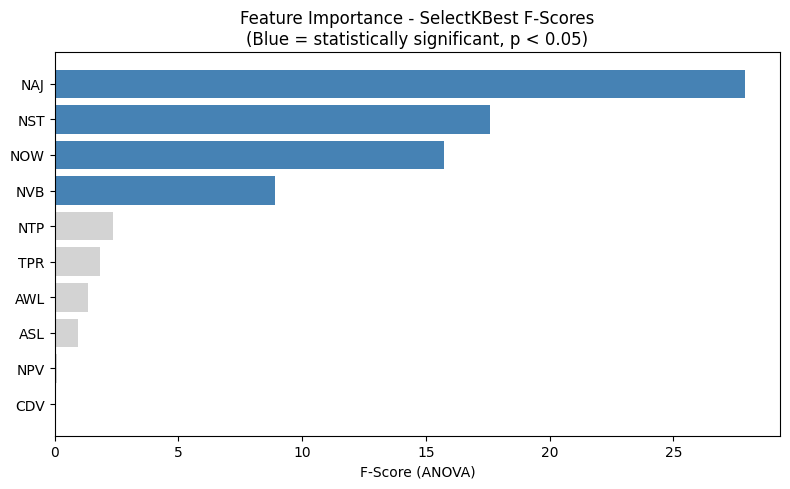

In [11]:
feature_scores_sorted = feature_scores.sort_values('F-Score', ascending=True)
colors = ['steelblue' if p < 0.05 else 'lightgray' for p in feature_scores_sorted['p-value']]
plt.figure(figsize=(8, 5))
plt.barh(feature_scores_sorted['Feature'], feature_scores_sorted['F-Score'], color=colors)
plt.xlabel('F-Score (ANOVA)')
plt.title('Feature Importance - SelectKBest F-Scores\n(Blue = statistically significant, p < 0.05)')
plt.tight_layout()
plt.show()

In [12]:
# Search over k values with multi-kernel grid
best_f1_cv_fs = 0
best_k = 10
best_svm_fs = None
best_selector = None
best_params_fs = None

print("Searching over k values with multi-kernel GridSearchCV...\n")

for k in range(3, 11):
    selector = SelectKBest(score_func=f_classif, k=k)
    X_selected = selector.fit_transform(X_train_val, y_train_val)
    selected = [feature_names[i] for i in selector.get_support(indices=True)]

    gs = GridSearchCV(
        SVC(random_state=101),
        param_grids,
        cv=5, scoring='f1', n_jobs=-1, refit=True
    )
    gs.fit(X_selected, y_train_val)

    cv_f1 = gs.best_score_

    X_test_sel = selector.transform(X_test)
    test_preds = gs.best_estimator_.predict(X_test_sel)
    test_f1 = f1_score(y_test, test_preds)
    test_acc = accuracy_score(y_test, test_preds)

    print(f"k={k:2d} | CV F1: {cv_f1:.4f} | Test Acc: {test_acc:.4f} | Test F1: {test_f1:.4f} | {gs.best_params_['kernel']:6s} | Features: {selected}")

    if cv_f1 > best_f1_cv_fs:
        best_f1_cv_fs = cv_f1
        best_k = k
        best_svm_fs = gs.best_estimator_
        best_selector = selector
        best_params_fs = gs.best_params_

print(f"\n=== Best: k={best_k} | CV F1: {best_f1_cv_fs:.4f} | Kernel: {best_params_fs['kernel']} ===")

Searching over k values with multi-kernel GridSearchCV...



k= 3 | CV F1: 0.6177 | Test Acc: 0.6538 | Test F1: 0.5714 | poly   | Features: ['NOW', 'NAJ', 'NST']


k= 4 | CV F1: 0.6444 | Test Acc: 0.7115 | Test F1: 0.6939 | rbf    | Features: ['NOW', 'NVB', 'NAJ', 'NST']


k= 5 | CV F1: 0.6231 | Test Acc: 0.6538 | Test F1: 0.6538 | rbf    | Features: ['NOW', 'NVB', 'NAJ', 'NST', 'NTP']


k= 6 | CV F1: 0.5996 | Test Acc: 0.7308 | Test F1: 0.7083 | linear | Features: ['NOW', 'NVB', 'NAJ', 'NST', 'NTP', 'TPR']


k= 7 | CV F1: 0.6207 | Test Acc: 0.7115 | Test F1: 0.6809 | poly   | Features: ['AWL', 'NOW', 'NVB', 'NAJ', 'NST', 'NTP', 'TPR']


k= 8 | CV F1: 0.6203 | Test Acc: 0.7115 | Test F1: 0.6667 | poly   | Features: ['AWL', 'ASL', 'NOW', 'NVB', 'NAJ', 'NST', 'NTP', 'TPR']


k= 9 | CV F1: 0.6014 | Test Acc: 0.7308 | Test F1: 0.6957 | linear | Features: ['AWL', 'ASL', 'NOW', 'NVB', 'NAJ', 'NPV', 'NST', 'NTP', 'TPR']


k=10 | CV F1: 0.6011 | Test Acc: 0.5769 | Test F1: 0.5417 | poly   | Features: ['AWL', 'ASL', 'NOW', 'NVB', 'NAJ', 'NPV', 'NST', 'CDV', 'NTP', 'TPR']

=== Best: k=4 | CV F1: 0.6444 | Kernel: rbf ===


In [13]:
selected_features = [feature_names[i] for i in best_selector.get_support(indices=True)]
print(f"Selected {best_k} features: {selected_features}")
print(f"Best Hyperparameters: {best_params_fs}")
print()

X_train_val_sel = best_selector.transform(X_train_val)
X_test_sel = best_selector.transform(X_test)

print(f"=== Best SVM with Feature Selection (k={best_k}, {best_svm_fs.kernel} kernel) ===")
acc_train_fs, f1_train_fs = evaluate(best_svm_fs, X_train_val_sel, y_train_val, "Train+Val")
acc_test_fs, f1_test_fs = evaluate(best_svm_fs, X_test_sel, y_test, "Test")

print(f"\nClassification Report (Test - Feature Selection):")
print(classification_report(y_test, best_svm_fs.predict(X_test_sel), target_names=["Fake", "Real"]))

Selected 4 features: ['NOW', 'NVB', 'NAJ', 'NST']
Best Hyperparameters: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}

=== Best SVM with Feature Selection (k=4, rbf kernel) ===
Train+Val - Accuracy: 67.31% | F1: 64.58%
Test - Accuracy: 71.15% | F1: 69.39%

Classification Report (Test - Feature Selection):
              precision    recall  f1-score   support

        Fake       0.69      0.77      0.73        26
        Real       0.74      0.65      0.69        26

    accuracy                           0.71        52
   macro avg       0.71      0.71      0.71        52
weighted avg       0.71      0.71      0.71        52



## Step 6 - Results Comparison

In [14]:
# Select best model based on test F1 (since both were tuned via CV)
if f1_test_fs >= f1_test_all:
    best_model = best_svm_fs
    best_model_name = f"SVM ({best_svm_fs.kernel}, k={best_k})"
    best_acc_train = acc_train_fs
    best_f1_train = f1_train_fs
    best_acc_test = acc_test_fs
    best_f1_test = f1_test_fs
    n_features = best_k
    best_final_params = best_params_fs
else:
    best_model = svm_all
    best_model_name = f"SVM ({svm_all.kernel}, all features)"
    best_acc_train = acc_train_all
    best_f1_train = f1_train_all
    best_acc_test = acc_test_all
    best_f1_test = f1_test_all
    n_features = 10
    best_final_params = grid_search.best_params_

comparison = pd.DataFrame({
    'Configuration': [f'All 10 Features ({svm_all.kernel})', f'SelectKBest k={best_k} ({best_svm_fs.kernel})'],
    'Train+Val Acc': [f"{acc_train_all*100:.2f}%", f"{acc_train_fs*100:.2f}%"],
    'Train+Val F1': [f"{f1_train_all*100:.2f}%", f"{f1_train_fs*100:.2f}%"],
    'Test Accuracy': [f"{acc_test_all*100:.2f}%", f"{acc_test_fs*100:.2f}%"],
    'Test F1': [f"{f1_test_all*100:.2f}%", f"{f1_test_fs*100:.2f}%"],
    '# Features': [10, best_k]
})

print("=== SVM Results Comparison ===")
print(comparison.to_string(index=False))
print(f"\nBenchmark: Accuracy 79.09%, F1 76.99%")
print(f"Best Model: {best_model_name}")

=== SVM Results Comparison ===
         Configuration Train+Val Acc Train+Val F1 Test Accuracy Test F1  # Features
All 10 Features (poly)        78.37%       77.83%        57.69%  54.17%          10
 SelectKBest k=4 (rbf)        67.31%       64.58%        71.15%  69.39%           4

Benchmark: Accuracy 79.09%, F1 76.99%
Best Model: SVM (rbf, k=4)


## Step 7 - Confusion Matrix

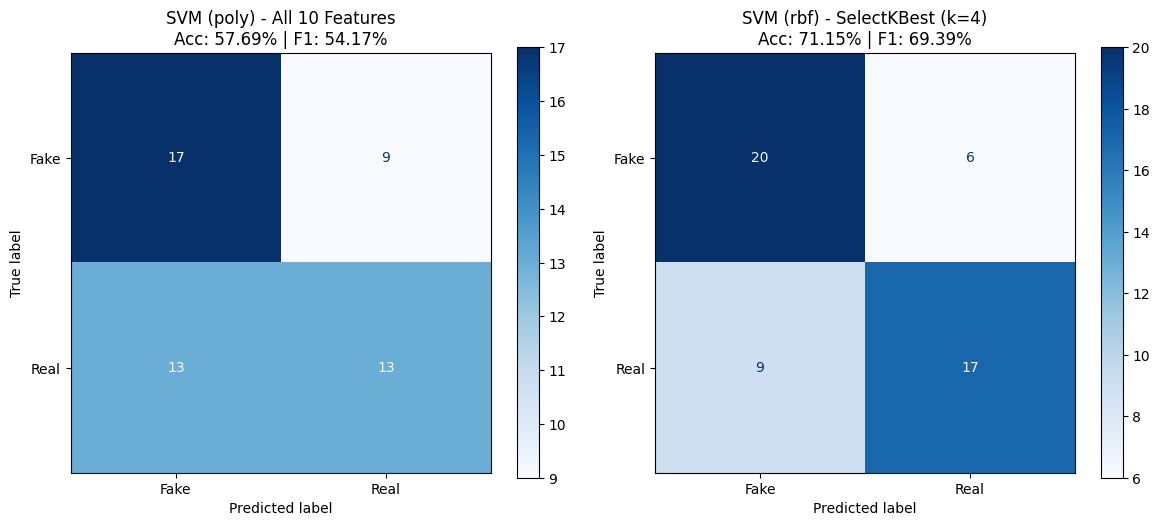

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# All features
cm_all = confusion_matrix(y_test, svm_all.predict(X_test))
disp_all = ConfusionMatrixDisplay(confusion_matrix=cm_all, display_labels=["Fake", "Real"])
disp_all.plot(ax=axes[0], cmap='Blues')
axes[0].set_title(f"SVM ({svm_all.kernel}) - All 10 Features\nAcc: {acc_test_all*100:.2f}% | F1: {f1_test_all*100:.2f}%")

# Feature selection
cm_fs = confusion_matrix(y_test, best_svm_fs.predict(X_test_sel))
disp_fs = ConfusionMatrixDisplay(confusion_matrix=cm_fs, display_labels=["Fake", "Real"])
disp_fs.plot(ax=axes[1], cmap='Blues')
axes[1].set_title(f"SVM ({best_svm_fs.kernel}) - SelectKBest (k={best_k})\nAcc: {acc_test_fs*100:.2f}% | F1: {f1_test_fs*100:.2f}%")

plt.tight_layout()
plt.show()

## Step 8 - Save Best Model

In [16]:
joblib.dump(best_model, 'best_svm_model.pkl')
joblib.dump(scaler, 'svm_scaler.pkl')
if f1_test_fs >= f1_test_all and best_selector is not None:
    joblib.dump(best_selector, 'svm_selector.pkl')

print(f"Saved best model: {best_model_name}")
print(f"Test Accuracy: {best_acc_test*100:.2f}%")
print(f"Test F1 Score: {best_f1_test*100:.2f}%")
print(f"Number of features used: {n_features}")
print(f"Most important feature: {feature_scores.iloc[0]['Feature']} (F-Score: {feature_scores.iloc[0]['F-Score']:.4f})")

Saved best model: SVM (rbf, k=4)
Test Accuracy: 71.15%
Test F1 Score: 69.39%
Number of features used: 4
Most important feature: NAJ (F-Score: 27.9092)


## Summary for Comparison Table

This cell outputs the values needed for the 3-model comparison table.

In [17]:
print("=" * 60)
print("SVM CLASSIFICATION - SUMMARY FOR COMPARISON TABLE")
print("=" * 60)
print(f"Model:                  SVM ({best_model.kernel.upper()} Kernel)")
print(f"Best Hyperparameters:   {best_final_params}")
print(f"Train+Val Accuracy:     {best_acc_train*100:.2f}%")
print(f"Train+Val F1 Score:     {best_f1_train*100:.2f}%")
print(f"Test Accuracy:          {best_acc_test*100:.2f}%")
print(f"Test F1 Score:          {best_f1_test*100:.2f}%")
print(f"# Selected Features:    {n_features}")
print(f"Most Important Feature: {feature_scores.iloc[0]['Feature']}")
print(f"Feature Ranking:        {feature_scores['Feature'].tolist()}")
print("=" * 60)
print(f"Benchmark - Accuracy: 79.09% | F1: 76.99%")

SVM CLASSIFICATION - SUMMARY FOR COMPARISON TABLE
Model:                  SVM (RBF Kernel)
Best Hyperparameters:   {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
Train+Val Accuracy:     67.31%
Train+Val F1 Score:     64.58%
Test Accuracy:          71.15%
Test F1 Score:          69.39%
# Selected Features:    4
Most Important Feature: NAJ
Feature Ranking:        ['NAJ', 'NST', 'NOW', 'NVB', 'NTP', 'TPR', 'AWL', 'ASL', 'NPV', 'CDV']
Benchmark - Accuracy: 79.09% | F1: 76.99%
